In [ ]:
The Task:
1) Goal to increase overall perfomance (rely on each metric), by choosing one of these pages:
    increase order value per view; - to earn more money
    increase overall purchase rate; - to increase average amount of purchases by user
    increase time spent on page per user. - to spend time not only for purchasing, but also increase their time searching for another products

2) Metrics:
    order_value per view - ratio;
    mean purchased - proportion;
    time_on_page per user - mean.
        I decided to place metrics in that way, since the main goal of any business is to make more money and make users to spend more. After completing thouse conditions it's nice to create ways to capture attention of our users to spend more.

3) How: demonstrating different checkout pages (A "default", B, C).

4) H0: in each of our test there is no differernce between groups;
   Ha: our alternative variant has "greater" value;
   p-value: 0.05;
   power: 0.8.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import  matplotlib.pyplot as plt

import pingouin
from scipy.stats import norm, chi2_contingency
from statsmodels.stats import power
import statsmodels.stats.multitest as smt
from statsmodels.stats.proportion import proportion_effectsize, proportions_ztest, proportion_confint

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("C:/Users/ASUS-X515EP/Downloads/checkout.csv", sep=';').drop_duplicates()
df.head()

,Unnamed: 0,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,0,877621,A,29.410131,1.0,F,chrome,66.168628
1,1,876599,A,NaN,0.0,M,firefox,49.801887
2,2,905407,A,27.446845,1.0,M,chrome,56.744856
3,3,883562,A,30.602233,1.0,M,safari,71.890718
4,4,840542,A,29.668895,1.0,F,safari,67.410696


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     9000 non-null   int64  
 1   user_id        9000 non-null   int64  
 2   checkout_page  9000 non-null   object 
 3   order_value    7605 non-null   float64
 4   purchased      9000 non-null   float64
 5   gender         9000 non-null   object 
 6   browser        9000 non-null   object 
 7   time_on_page   9000 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 562.6+ KB


In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Unnamed: 0          0
user_id             0
checkout_page       0
order_value      1395
purchased           0
gender              0
browser             0
time_on_page        0
dtype: int64

In [6]:
df.head()

,Unnamed: 0,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,0,877621,A,29.410131,1.0,F,chrome,66.168628
1,1,876599,A,NaN,0.0,M,firefox,49.801887
2,2,905407,A,27.446845,1.0,M,chrome,56.744856
3,3,883562,A,30.602233,1.0,M,safari,71.890718
4,4,840542,A,29.668895,1.0,F,safari,67.410696


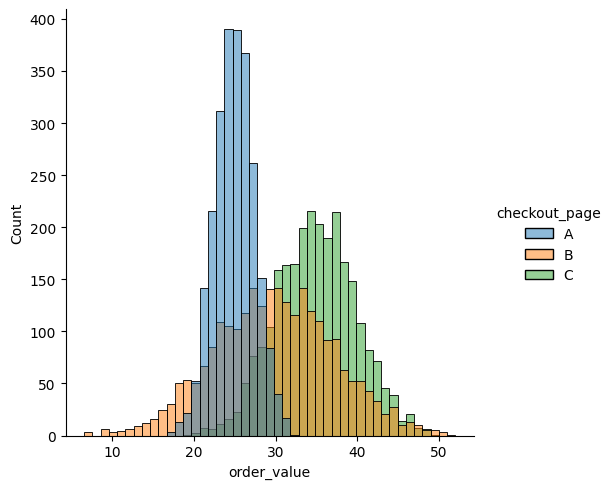

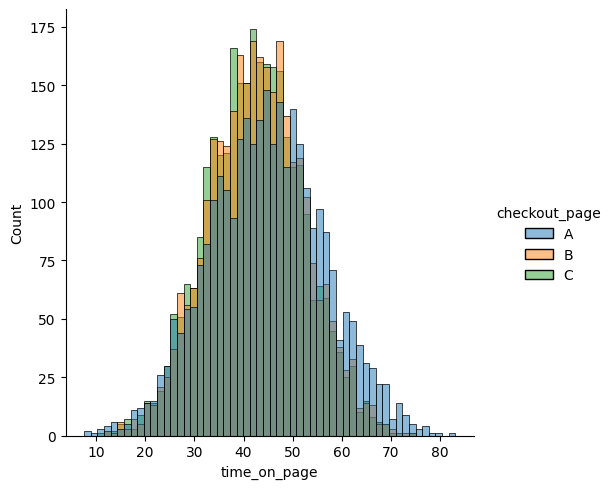

In [7]:
# Distribution of numeric values.
for i in ['order_value', 'time_on_page']:
    sns.displot(
        data=df,
        x=i,
        hue='checkout_page')
plt.show()

<Axes: xlabel='checkout_page', ylabel='proportion'>

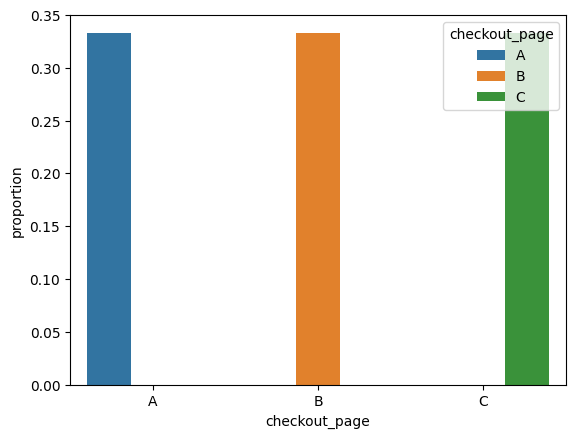

In [8]:
# Ptoportion of groups.
df_prop = pd.DataFrame(df.checkout_page.value_counts(normalize=True).reset_index()) #.plot(kind='bar', color='checkout_page')
sns.barplot(df_prop, x='checkout_page', y='proportion', hue='checkout_page')

In [9]:
df.groupby(['checkout_page', 'gender']).browser.value_counts(normalize=True)

checkout_page  gender  browser
A              F       chrome     0.342088
                       safari     0.340741
                       firefox    0.317172
               M       chrome     0.340594
                       firefox    0.335974
                       safari     0.323432
B              F       safari     0.362681
                       chrome     0.331800
                       firefox    0.305519
               M       firefox    0.345061
                       safari     0.341001
                       chrome     0.313938
C              F       firefox    0.337604
                       chrome     0.331839
                       safari     0.330557
               M       safari     0.362752
                       chrome     0.328006
                       firefox    0.309243
Name: proportion, dtype: float64

## Функції для роботи

In [10]:
# To identify effect size.
def cohens_d(group1, group2):
    diff = group2.mean() - group1.mean()
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    d = diff / pooled_std
    return d

In [11]:
# As value order per user it is a complex metrics (with includes 2 variables, which haves different std) - we should use delta method.
# Variation for delta method.
def var_delta(x,y): 
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    x_var = np.var(x, ddof=1)
    y_var = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]    
    var_ratio = (x_var / y_bar**2 + y_var * (x_bar**2 / y_bar**4) - 2 * cov_xy * (x_bar / y_bar ** 3)) / len(x)
    return var_ratio

In [35]:
# Calulating p-value
def ztest_delta(x_control, y_control, x_treatment, y_treatment, alpha=0.05):
    mean_control = x_control.sum() / y_control.sum()
    mean_treatment = x_treatment.sum() / y_treatment.sum()
    var_control = var_delta(x_control, y_control)
    var_treatment = var_delta(x_treatment, y_treatment)
    diff = mean_treatment - mean_control
    var = var_control + var_treatment
    
    # Calculate the two-tailed critical value
    cv = norm.ppf(1 - alpha / 2)
    
    # Calculate the z_stat
    z_stat = diff / np.sqrt(var)
    
    # Calculate the p-value
    p_val = norm.sf(abs(z_stat)) * 2.0
    
    # Calculate confidence intervals of the difference
    stde = cv * np.sqrt(var)
    lower = diff - stde 
    upper = diff + stde
    
    result = {'mean_control':mean_control,
              'mean_treatment':mean_treatment,
              'difference':round(diff, 3),
              'diff_CI':"["+str(round(lower,3))+", "+str(round(upper,3))+"]",
              'p-value':p_val}
    return result

# A/B Testing

In [18]:
# Page A is a default one.
print(f"Default purchase rate: {df[df['checkout_page']=='A'].purchased.mean()}")
print(f"Default order value: {df[df['checkout_page']=='A'].groupby('user_id')['order_value'].sum().sum() / df[df['checkout_page']=='A'].groupby('user_id')['user_id'].count().sum()}")
print(f"Default time on page: {df[df['checkout_page']=='A'].time_on_page.mean()}")

Default purchase rate: 0.8203333333333334
Default order value: 20.472597188012
Default time on page: 44.668526676641186


In [19]:
# Identify, if there are any uneven groups.
expected, observed, stats = pingouin.chi2_independence(
    data=df, 
    x='checkout_page',
    y='browser', 
    correction=False
)

print(stats[stats['test']=='pearson'])
# Оскільки p-value > 0.05 - спостереження незалежні, тому групи розподілені однаквово між собою.

      test  lambda      chi2  dof      pval    cramer     power
0  pearson     1.0  3.423705  4.0  0.489574  0.013792  0.151602


## Order value per user

In [20]:
# Check normality of each group
normality = pingouin.normality(
        data=df,
        dv='order_value',
        group='checkout_page',
        method='normaltest',
        alpha=0.05)
print(normality)
# p-val > 0.05 - groups have norm dist. 

                      W      pval  normal
checkout_page                            
A              1.876135  0.391383    True
B              2.019789  0.364257    True
C              2.803774  0.246132    True


### A and B

In [22]:
print(f"Effect size: {cohens_d(df[df['checkout_page']=='A']['order_value'], df[df['checkout_page']=='B']['order_value']):.2f}")
# This effect size is considered to be large.

Effect size: 0.91


In [23]:
# The power of our test.
effect_size = cohens_d(df[df['checkout_page']=='A']['order_value'], df[df['checkout_page']=='B']['order_value'])
power.NormalIndPower().power(effect_size=effect_size,
                                alpha=0.05,
                                nobs1=3000)
# We have ~100% chance to identify difference, if it exists between groups A and B.

1.0

In [36]:
# Between A and B
A_per_user = pd.DataFrame({
    'order_value':df[df['checkout_page']=='A'].groupby('user_id')['order_value'].sum(),
    'page_view':df[df['checkout_page']=='A'].groupby('user_id')['user_id'].count()
})

B_per_user = pd.DataFrame({
    'order_value':df[df['checkout_page']=='B'].groupby('user_id')['order_value'].sum(),
    'page_view':df[df['checkout_page']=='B'].groupby('user_id')['user_id'].count()
})

x_control = A_per_user['order_value']
y_control = A_per_user['page_view']
x_treatment = B_per_user['order_value']
y_treatment = B_per_user['page_view']

p_val_AB_order_value = ztest_delta(x_control, y_control, x_treatment, y_treatment)

print(f'p-value: {p_val_AB_order_value["p-value"]}')
print(f'difference between groups: {p_val_AB_order_value["difference"]}')
print(f'CI for difference: {p_val_AB_order_value["diff_CI"]}')
# As p-value < 0.05 - we reject our null hypothesis. -> B > A

p-value: 5.954978880471644e-61
difference between groups: 4.833
CI for difference: [4.257, 5.408]


### A and C

In [37]:
print(f"Effect size: {cohens_d(df[df['checkout_page']=='A']['order_value'], df[df['checkout_page']=='C']['order_value']):.2f}")
# This effect size is considered to be very large.

Effect size: 2.59


In [38]:
# The power of our test.
effect_size = cohens_d(df[df['checkout_page']=='A']['order_value'], df[df['checkout_page']=='C']['order_value'])
power.NormalIndPower().power(effect_size=effect_size,
                                alpha=0.05,
                                nobs1=3000)
# We have 100% chance to identify difference, if it exists between groups A and C.

1.0

In [39]:
# Between A and C
A_per_user = pd.DataFrame({
    'order_value':df[df['checkout_page']=='A'].groupby('user_id')['order_value'].sum(),
    'page_view':df[df['checkout_page']=='A'].groupby('user_id')['user_id'].count()
})

C_per_user = pd.DataFrame({
    'order_value':df[df['checkout_page']=='C'].groupby('user_id')['order_value'].sum(),
    'page_view':df[df['checkout_page']=='C'].groupby('user_id')['user_id'].count()
})

x_control = A_per_user['order_value']
y_control = A_per_user['page_view']
x_treatment = C_per_user['order_value']
y_treatment = C_per_user['page_view']

p_val_AC_order_value = ztest_delta(x_control, y_control, x_treatment, y_treatment)

print(f'p-value: {p_val_AC_order_value["p-value"]}')
print(f'difference between groups: {p_val_AC_order_value["difference"]}')
print(f'CI for difference: {p_val_AC_order_value["diff_CI"]}')
# As p-value < 0.05 - we reject our null hypothesis. -> C > A

p-value: 1.5695484218904422e-246
difference between groups: 9.824
CI for difference: [9.25, 10.398]


### B and C

In [40]:
print(f"Effect size: {cohens_d(df[df['checkout_page']=='B']['order_value'], df[df['checkout_page']=='C']['order_value']):.2f}")
# This effect size is considered to be large between B and C.

Effect size: 0.81


In [41]:
# Between B and C (the final choice)
B_per_user = pd.DataFrame({
    'order_value':df[df['checkout_page']=='B'].groupby('user_id')['order_value'].sum(),
    'page_view':df[df['checkout_page']=='B'].groupby('user_id')['user_id'].count()
})

C_per_user = pd.DataFrame({
    'order_value':df[df['checkout_page']=='C'].groupby('user_id')['order_value'].sum(),
    'page_view':df[df['checkout_page']=='C'].groupby('user_id')['user_id'].count()
})

x_control = B_per_user['order_value']
y_control = B_per_user['page_view']
x_treatment = C_per_user['order_value']
y_treatment = C_per_user['page_view']

p_val_BC_order_value = ztest_delta(x_control, y_control, x_treatment, y_treatment)

print(f'p-value: {p_val_BC_order_value["p-value"]}')
print(f'difference between groups: {p_val_BC_order_value["difference"]}')
print(f'CI for difference: {p_val_BC_order_value["diff_CI"]}')
# As p-value < 0.05 - we reject our null hypothesis. -> C > B

p-value: 1.0974571031912711e-52
difference between groups: 4.992
CI for difference: [4.351, 5.632]


In [42]:
# Apply correction.
pvals=[5.954978880471644e-61, 1.5695484218904422e-246, 1.0974571031912711e-52]

corrected = smt.multipletests(pvals, 
                                alpha=0.05, 
                                method='sidak')
print(corrected)

(array([ True,  True,  True]), array([1.78649366e-060, 4.70864527e-246, 3.29237131e-052]), 0.016952427508441503, 0.016666666666666666)


In [ ]:
As we observed, there is exists signifficant difference with large effect sizes between A and B; A and C. So i tested difference between B and C. 
    As the result - page "C" has the largest order value per user, since p-value is small and effect size is large.

## Purchase rate

In [162]:
# There is no need in normal-distribution, as it proportion test and chi2-test does not demand parametric conditions.

<Axes: xlabel='checkout_page', ylabel='purchased'>

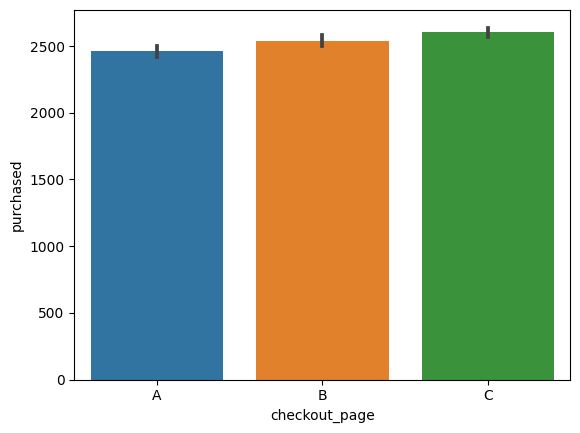

In [390]:
# Distribution of those, who made a purchase
sns.barplot(data=df,
           x='checkout_page',
           y='purchased',
           estimator='sum')

### A and B

In [43]:
p_A = (df[df['checkout_page']=='A']['purchased']).mean()
p_B = (df[df['checkout_page']=='B']['purchased']).mean()

effect_size = proportion_effectsize(p_B, p_A)
print(f'Effect size: {effect_size:.3f}')
# Effect size is small.

Effect size: 0.072


In [44]:
# The power of our test.
power.TTestIndPower().power(effect_size=effect_size,
                                alpha=0.05,
                                nobs1=3000)
# We have ~80% chance to identify difference, if it exists between groups A and B.

0.7924991154351732

In [55]:
# Independence between A and B
n_A = df[df['checkout_page'] == "A"]['user_id'].nunique()
n_B = df[df['checkout_page'] == 'B']['user_id'].nunique()

signup_A = df[df['checkout_page'] == 'A'].groupby('user_id')['purchased'].max().sum()
no_signup_A = n_A - signup_A
signup_B = df[df['checkout_page'] == 'B'].groupby('user_id')['purchased'].max().sum()
no_signup_B = n_B - signup_B

table = [[signup_A, no_signup_A], [signup_B, no_signup_B]]
print('Group A signup rate:', round(signup_A / n_A, 3))
print('Group B signup rate:', round(signup_B / n_B, 3))

print('p-value:', chi2_contingency(table, correction=False)[1])
# p-value < 0.05, they are dependent, so there is exists a difference.

Group A signup rate: 0.821
Group B signup rate: 0.848
p-value: 0.005765187821271246


In [51]:
signups_abtest = [signup_A, signup_B]
n_abtest = [n_A, n_B]

z_stat, pvalue = proportions_ztest(
    signups_abtest,
    nobs=n_abtest)

(A_lo95, B_lo95), (A_up95, B_up95) = proportion_confint(
    signups_abtest,
    nobs=n_abtest,
    alpha=0.05)

print(f'p-value: {pvalue:.4f}')
print(f'Group A 95% CI : [{A_lo95:.4f}, {A_up95:.4f}]')
print(f'Group B 95% CI : [{B_lo95:.4f}, {B_up95:.4f}]')
# As p-value < 0.05 - we reject our null hypothesis. -> B > A

p-value: 0.0058
Group A 95% CI : [0.8072, 0.8349]
Group B 95% CI : [0.8349, 0.8608]


### A and C

In [56]:
p_A = (df[df['checkout_page']=='A']['purchased']).mean()
p_C = (df[df['checkout_page']=='C']['purchased']).mean()

effect_size = proportion_effectsize(p_C, p_A)
print(f'Effect size: {effect_size:.3f}')
# Effect size is small.

Effect size: 0.131


In [57]:
# The power of our test
power.TTestIndPower().power(effect_size=effect_size,
                                alpha=0.05,
                                nobs1=3000)
# We have ~100% chance to identify difference, if it exists between groups A and C.

0.9990478888008646

In [58]:
# Between A and C
n_A = df[df['checkout_page'] == 'A']['user_id'].nunique()
n_C = df[df['checkout_page'] == 'C']['user_id'].nunique()

signup_A = df[df['checkout_page'] == 'A'].groupby('user_id')['purchased'].max().sum()
no_signup_A = n_A - signup_A
signup_C = df[df['checkout_page'] == 'C'].groupby('user_id')['purchased'].max().sum()
no_signup_C = n_C - signup_C

table = [[signup_A, no_signup_A], [signup_C, no_signup_C]]
print('Group A signup rate:',round(signup_A/n_A,3))
print('Group C signup rate:',round(signup_C/n_C,3))


print('p-value:', chi2_contingency(table, correction=False)[1])
# There is dependency between A and C, so we can conduct z-test.

Group A signup rate: 0.821
Group C signup rate: 0.87
p-value: 2.4875094762199836e-07


In [67]:
signups_actest = [signup_A, signup_C]
n_actest = [n_A, n_C]

z_stat, pvalue = proportions_ztest(
    signups_actest,
    nobs=n_actest
)

(A_lo95, C_lo95), (A_up95, C_up95) = proportion_confint(
    signups_actest,
    nobs=n_actest,
    alpha=0.05)

print(f'p-value: {pvalue:.4f}')
print(f'Group A 95% CI : [{A_lo95:.4f}, {A_up95:.4f}]')
print(f'Group C 95% CI : [{C_lo95:.4f}, {C_up95:.4f}]')
# As p-value < 0.05 - we reject our null hypothesis. -> C > A

p-value: 0.0000
Group A 95% CI : [0.8072, 0.8349]
Group C 95% CI : [0.8575, 0.8818]


### B and C

In [68]:
p_B = (df[df['checkout_page']=='B']['purchased']).mean()
p_C = (df[df['checkout_page']=='C']['purchased']).mean()

effect_size = proportion_effectsize(p_C, p_B)
print(f'Effect size: {effect_size:.3f}')
# Effect size is small.

Effect size: 0.059


In [69]:
# The power of our test
power.TTestIndPower().power(effect_size=effect_size,
                                alpha=0.05,
                                nobs1=3000)
# We have ~63% chance to identify difference, if it exists between groups B and C.

0.6291979008533727

In [70]:
# Between B and C
n_B = df[df['checkout_page'] == 'B']['user_id'].nunique()
n_C = df[df['checkout_page'] == 'C']['user_id'].nunique()

signup_B = df[df['checkout_page'] == 'B'].groupby('user_id')['purchased'].max().sum()
no_signup_B = n_B - signup_B
signup_C = df[df['checkout_page'] == 'C'].groupby('user_id')['purchased'].max().sum()
no_signup_C = n_C - signup_C

table = [[signup_B, no_signup_B], [signup_C, no_signup_C]]
print('Group B signup rate:',round(signup_B/n_B,3))
print('Group C signup rate:',round(signup_C/n_C,3))

print('p-value:', chi2_contingency(table, correction=False)[1])
# There is dependency between B and C, so we can conduct z-test.

Group B signup rate: 0.848
Group C signup rate: 0.87
p-value: 0.016217310996546656


In [76]:
signups_bctest = [signup_B, signup_C]
n_bctest = [n_B, n_C]

z_stat, pvalue = proportions_ztest(
    signups_bctest,
    nobs=n_bctest
)

(B_lo95, C_lo95), (B_up95, C_up95) = proportion_confint(
    signups_bctest,
    nobs=n_bctest,
    alpha=0.05)

print(f'p-value: {pvalue:.4f}')
print(f'Group B 95% CI : [{B_lo95:.4f}, {B_up95:.4f}]')
print(f'Group C 95% CI : [{C_lo95:.4f}, {C_up95:.4f}]')
# As p-value < 0.05 - we reject our null hypothesis. -> C > B

p-value: 0.0162
Group B 95% CI : [0.8349, 0.8608]
Group C 95% CI : [0.8575, 0.8818]


In [77]:
# Apply correction.
pvals=[0.005765187821271246, 2.487509476219933e-07, 0.01621731099654653]

corrected = smt.multipletests(pvals, 
                                alpha=0.05, 
                                method='sidak')
print(corrected)

(array([ True,  True,  True]), array([1.71960429e-02, 7.46252657e-07, 4.78671946e-02]), 0.016952427508441503, 0.016666666666666666)


## Time spent on page per user

In [281]:
# Check normality of each group.
normality = pingouin.normality(
    data=df,
    dv='time_on_page',
    group='checkout_page',
    method='jarque_bera',
    alpha=0.05)
print(normality)

                      W     pval  normal
checkout_page                           
A              1.880245  0.39058    True
B              1.880245  0.39058    True
C              1.880245  0.39058    True


### A and B

In [166]:
print(f"Effect size: {cohens_d(df[df['checkout_page']=='A']['time_on_page'], df[df['checkout_page']=='B']['time_on_page']):.2f}")
# This effect size is negative and small, that mean, that B has less "times_on_page", if we compare it with A.

Effect size: -0.18


In [201]:
# The power of our test.
effect_size = cohens_d(df[df['checkout_page']=='A']['time_on_page'], df[df['checkout_page']=='B']['time_on_page'])
power.NormalIndPower().power(effect_size=effect_size,
                                alpha=0.05,
                                nobs1=3000)
# We have ~100% chance to identify difference, if it exists between groups A and B.

0.9999997976243107

In [285]:
# Between A and B
test_ab = pingouin.ttest(x=df[df['checkout_page']=='B']['time_on_page'], 
                        y=df[df['checkout_page']=='A']['time_on_page'], 
                        alternative="two-sided")
print(f'p-value: {test_ab["p-val"][0]}')
print(f'CI for difference: {test_ab["CI95%"][0]}')
# As p-value < 0.05, but B < A, so the default option is better.

p-value: 2.349604146429548e-12
CI for difference: [-2.49 -1.4 ]


### A and C

In [218]:
print(f"Effect size: {cohens_d(df[df['checkout_page']=='A']['time_on_page'], df[df['checkout_page']=='C']['time_on_page']):.2f}")
# This effect size is negative and small, that mean, that C has less "times_on_page", if we compare it with A.

Effect size: -0.23


In [350]:
# Between A and C
test_ac = pingouin.ttest(x=df[df['checkout_page']=='C']['time_on_page'], 
                y=df[df['checkout_page']=='A']['time_on_page'], 
                alternative="two-sided")

print(f'p-value: {test_ac["p-val"][0]}')
print(f'CI for difference: {test_ac["CI95%"][0]}')
# As p-value < 0.05, but C < A, so the default option is better.

p-value: 1.3161178697765583e-18
CI for difference: [-2.99 -1.9 ]


### B and C

In [290]:
print(f"Effect size: {cohens_d(df[df['checkout_page']=='B']['time_on_page'], df[df['checkout_page']=='C']['time_on_page']):.2f}")
# This effect size is negative and small.

Effect size: -0.05


In [345]:
# Between B and C
test_bc = pingouin.ttest(x=df[df['checkout_page']=='C']['time_on_page'], 
                            y=df[df['checkout_page']=='B']['time_on_page'], 
                            alternative="less")

print(f'p-value: {test_bc["p-val"][0]}')
print(f'CI for difference: {test_bc["CI95%"][0]}')
# As p-value < 0.05, but C < B, so the option "B" is better. But, if we apply Sidak correction - there is no signifficant difference.

p-value: 0.023020974035858878
CI for difference: [ -inf -0.09]


In [346]:
# Apply correction.
pvals=[2.349604146429548e-12, 1.3161178697765583e-18, 0.023020974035858878]

corrected = smt.multipletests(pvals, 
                                alpha=0.05, 
                                method='sidak')
print(corrected)

(array([ True,  True, False]), array([7.04881244e-12, 3.94835361e-18, 6.74852267e-02]), 0.016952427508441503, 0.016666666666666666)


In [ ]:
As we observed, the default option "A" is signifficantly better, than B and C, that is why users are more likely to spend more time on the old page. 

## Partial conclusion

In [ ]:
If we consider to increase our sales per view and purchase rate - "C" would be the best choice, but audience will spend less time on our website. 
Pageview "A" can keep the user on the page longer, than other options, however, financial aspect here has the worst perfomance.

As we have this uncertainty in time spend on page - it's better to conduct additional analysis, where i will explore time spent on pageview between users, who made a purchase and those, who didn't.

## Additional analysis of "avg page time per group"

In [386]:
pairwise = pingouin.pairwise_tests(data=df, 
                                    dv='time_on_page', 
                                    between=['purchased', 'checkout_page'],
                                    subject='user_id',
                                    padjust='sidak',
                                    alpha=0.05,
                                    alternative="greater",
                                    effsize='cohen',           # known estimator of "effect size"
                                    correction=True            # uneven sizes of the groups and heteroscedasticity
                                  )

pairwise

,Contrast,purchased,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,purchased,-,0.0,1.0,False,True,-1.924164,1926.437966,greater,9.727594e-01,NaN,NaN,0.415,-0.056517
1,checkout_page,-,A,B,False,True,7.026673,5809.098907,greater,1.178802e-12,3.536504e-12,sidak,2.611e+09,0.181428
2,checkout_page,-,A,C,False,True,8.833244,5809.098907,greater,6.635541e-19,0.000000e+00,sidak,3.622e+15,0.228073
3,checkout_page,-,B,C,False,True,1.995423,5998.000000,greater,2.302097e-02,6.748523e-02,sidak,0.424,0.051522
4,purchased * checkout_page,0.0,A,B,False,True,2.940592,994.778280,greater,1.675844e-03,1.001303e-02,sidak,9.912,0.183887
5,purchased * checkout_page,0.0,A,C,False,True,3.763482,927.435018,greater,8.904654e-05,5.341603e-04,sidak,150.356,0.240788
6,purchased * checkout_page,0.0,B,C,False,True,0.937999,841.944297,greater,1.742570e-01,6.829926e-01,sidak,0.236,0.064169
7,purchased * checkout_page,1.0,A,B,False,True,6.454550,4790.764012,greater,5.963947e-11,3.578371e-10,sidak,6.13e+07,0.183068
8,purchased * checkout_page,1.0,A,C,False,True,8.130901,4809.526528,greater,2.686638e-16,1.332268e-15,sidak,1.059e+13,0.229726
9,purchased * checkout_page,1.0,B,C,False,True,1.843407,5139.861368,greater,3.266356e-02,1.806579e-01,sidak,0.342,0.051406


In [387]:
# Apply correction.
pvals = pairwise['p-unc'].to_list()

corrected = smt.multipletests(pvals, 
                                alpha=0.05, 
                                method='sidak')
pairwise['accept'] = pd.DataFrame(corrected[0])

In [388]:
pairwise
# Doesn't matter, if user bought something or not - "A" page is the best in holding the user on the website.

,Contrast,purchased,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen,accept
0,purchased,-,0.0,1.0,False,True,-1.924164,1926.437966,greater,9.727594e-01,NaN,NaN,0.415,-0.056517,False
1,checkout_page,-,A,B,False,True,7.026673,5809.098907,greater,1.178802e-12,3.536504e-12,sidak,2.611e+09,0.181428,True
2,checkout_page,-,A,C,False,True,8.833244,5809.098907,greater,6.635541e-19,0.000000e+00,sidak,3.622e+15,0.228073,True
3,checkout_page,-,B,C,False,True,1.995423,5998.000000,greater,2.302097e-02,6.748523e-02,sidak,0.424,0.051522,False
4,purchased * checkout_page,0.0,A,B,False,True,2.940592,994.778280,greater,1.675844e-03,1.001303e-02,sidak,9.912,0.183887,True
5,purchased * checkout_page,0.0,A,C,False,True,3.763482,927.435018,greater,8.904654e-05,5.341603e-04,sidak,150.356,0.240788,True
6,purchased * checkout_page,0.0,B,C,False,True,0.937999,841.944297,greater,1.742570e-01,6.829926e-01,sidak,0.236,0.064169,False
7,purchased * checkout_page,1.0,A,B,False,True,6.454550,4790.764012,greater,5.963947e-11,3.578371e-10,sidak,6.13e+07,0.183068,True
8,purchased * checkout_page,1.0,A,C,False,True,8.130901,4809.526528,greater,2.686638e-16,1.332268e-15,sidak,1.059e+13,0.229726,True
9,purchased * checkout_page,1.0,B,C,False,True,1.843407,5139.861368,greater,3.266356e-02,1.806579e-01,sidak,0.342,0.051406,False


# Conclusion

In [ ]:
    As there is no difference between those groups, who made a purchases and who didn't - it means that option "A" is the best in "avg time spent per user". However, i think, that user spend more time on it due to unintuitive design, since more time on page by user don't make him or her spend more money. 
    As the "C" have the best perfomance in making money - it will be the final choice.